## Code for creating "demographic ratios," "demographic variables," other variables needed for the "historical regression" (based on Higgins, 1998, International Economic Review), and executing the said regression

This notebook was written to execute the following tasks:
- Create "demographic ratios," which are the shares of specific age-groups (0-4, 5-9, ..., 65-69, and 70+) for each country; these will be made in five-year moving averages, for the "historical regression" (based on Higgins, 1998, Int. Econ. Rev.)
- Create "demographic variables," which are created from the demographic ratios and are used the historical regression
- Create other variables created from on GDPpc and its grwoth rate to be used in the historical regression
- Conduct the historical regression and project missing values for the I-Y ratios

## Setting

### Importing necessary modules

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm.auto import tqdm

from sliiders import country_level_ypk as ypk_fn
from sliiders import settings as sset

## Creating (five-year averages of) demographic ratios

### Importing necessary datasets

We note that the population values in the dataset we cleaned up is in millions of people whereas the UN data is in thousands of people. Therefore, we will divide the columns `PopMale`, `PopFemale`, and `PopTotal` by 1000 to keep all values in millions of people.

In [4]:
# overall population stuff
pop = pd.read_parquet(
    sset.DIR_YPK_INT / "gdp_gdppc_pop_capital_1950_2020_post_ypk3.parquet"
)

# let us set aside the uninhabited areas
pop = pop.loc[
    ~pop.index.get_level_values("ccode").isin(sset.UNINHABITED_ISOS), :
].sort_index()
ccodes = pop.index.get_level_values("ccode").unique()

# by-age population
by_age = pd.read_parquet(sset.DIR_YPK_INT / "un_population_by_age.parquet")
for i in ["PopMale", "PopFemale", "PopTotal"]:
    by_age[i] = by_age[i] / 1000

### Gathering the age groups

#### For all countries

In [7]:
## generating groups
yrs = np.arange(0, 70, 5)
groups = ["-".join([str(x), str(x + 4)]) for x in yrs]

## easier mapping from group names to group numbering
dic = dict(zip(groups, range(1, len(groups) + 1)))
case_df = pd.DataFrame(
    np.vstack([list(dic.keys()), list(dic.values())]).T, columns=["AgeGrp", "group_num"]
)

## group numbering attach
by_age_cleaning = by_age.reset_index().merge(case_df, on="AgeGrp", how="left")

## if no group number (i.e., the highest age group), just create a new one
by_age_cleaning.loc[pd.isnull(by_age_cleaning.group_num), "group_num"] = (
    max(list(dic.values())) + 1
)

## gathering by the generated group numberings
by_age_cleaning = by_age_cleaning.groupby(["ccode", "Time", "group_num"]).sum()
by_age_cleaning.reset_index(inplace=True)

## reorganizing, data type-setting
by_age_cleaning = by_age_cleaning.astype({"Time": "int64", "group_num": "int64"})
by_age_cleaning.rename(columns={"Time": "year"}, inplace=True)
by_age_cleaning.set_index(["ccode", "year", "group_num"], inplace=True)
by_age_cleaning.sort_index(inplace=True)

## Only want 2020 and before
by_age_cleaning = by_age_cleaning.loc[
    by_age_cleaning.index.get_level_values("year") <= 2020, ["PopTotal"]
].copy()

## again, cleaning and merging in the group names
case_df = case_df.astype({"group_num": "int64"}).set_index(["group_num"])
by_age_cleaning = by_age_cleaning.merge(
    case_df, left_index=True, right_index=True, how="left"
)

## if missing group name, this should be for over 70+
by_age_cleaning.loc[pd.isnull(by_age_cleaning.AgeGrp), "AgeGrp"] = "70+"

#### Taking care of the Channel Islands, and setting aside their information

We find that the `grps_df` actually includes the information for the Channel Islands, which we can separate out to Guernsey and Jersey (`GGY` and `JEY`). In the said separation effort, what we will do is to use the average ratio of `GGY` population and `JEY` population between the years 2009-2019 as noted in the previous file (`ypk3_reorg_and_impute_ypk.ipynb`). The reason for using the years 2009-2019 is because we have actual data for `GGY` for those years in Guernsey Annual Electronic Report.

In [8]:
## GGY and JEY ratios
ggy_0919 = pop.loc[("GGY", list(range(2009, 2020))), "pop"].values
jey_0919 = pop.loc[("JEY", list(range(2009, 2020))), "pop"].values
ggy_ratio = (ggy_0919 / (ggy_0919 + jey_0919)).mean()
jey_ratio = (jey_0919 / (ggy_0919 + jey_0919)).mean()

## separating out JEY and GGY
channel = by_age_cleaning.loc[("GGY+JEY", slice(None), slice(None)), :].copy()
ggy, jey = channel.reset_index(), channel.reset_index()
ggy["PopTotal"] = ggy["PopTotal"].values * ggy_ratio
jey["PopTotal"] = jey["PopTotal"].values * jey_ratio
ggy["ccode"], jey["ccode"] = "GGY", "JEY"
ggy.set_index(["ccode", "year", "group_num"], inplace=True)
jey.set_index(["ccode", "year", "group_num"], inplace=True)

## merging stuff together
by_age_cleaning = pd.concat(
    [
        ggy,
        jey,
        by_age_cleaning.loc[
            by_age_cleaning.index.get_level_values("ccode") != "GGY+JEY", :
        ],
    ],
    axis=0,
).sort_index()

### Creating demographic ratios of age-group population 5-year-averages, and extrapolating for missing countries

#### 5-year-averages of age-group population

To be exact, this would be the 5 previous years' averages. If there are less than 5 previous years available (for 1950-1954), we use whatever previous years we have, with the exception of year 1950 where the 1950 values are copied due to lack of previous-years data.

In [9]:
by_age_cleaning["avg_5_yrs"] = np.nan

for i in tqdm(range(1950, 2021)):
    if i in [1950, 1951]:
        by_age_cleaning.loc[(slice(None), i), "avg_5_yrs"] = by_age_cleaning.loc[
            (slice(None), 1950), "PopTotal"
        ].values
        continue
    elif i in [1952, 1953, 1954]:
        prev_yrs = list(range(1950, i))
    else:
        prev_yrs = list(range(i - 5, i))

    for j, yr in enumerate(prev_yrs):
        name = "pop_{}".format(yr)
        yr_df = by_age_cleaning.loc[(slice(None), yr, slice(None)), ["PopTotal"]]
        yr_df.reset_index(inplace=True)
        yr_df.drop(["year"], inplace=True, axis=1)
        yr_df.rename(columns={"PopTotal": name}, inplace=True)
        yr_df.set_index(["ccode", "group_num"], inplace=True)

        if j == 0:
            prev_df = yr_df.copy()
        else:
            prev_df = prev_df.merge(
                yr_df, left_index=True, right_index=True, how="left"
            )

    prev_df["prev_mean"] = prev_df[["pop_{}".format(x) for x in prev_yrs]].mean(axis=1)
    prev_df.reset_index(inplace=True)
    prev_df["year"] = i
    prev_df.set_index(["ccode", "year", "group_num"], inplace=True)
    by_age_cleaning = by_age_cleaning.merge(
        prev_df[["prev_mean"]], left_index=True, right_index=True, how="left"
    )
    by_age_cleaning.loc[(slice(None), i), "avg_5_yrs"] = by_age_cleaning.loc[
        (slice(None), i), "prev_mean"
    ].values
    by_age_cleaning.drop(["prev_mean"], inplace=True, axis=1)

  0%|          | 0/71 [00:00<?, ?it/s]

#### Creating the demographic ratios

In [10]:
total = by_age_cleaning.reset_index().groupby(["ccode", "year"]).sum()[["avg_5_yrs"]]
total.rename(columns={"avg_5_yrs": "total"}, inplace=True)
by_age_cleaning = by_age_cleaning.merge(
    total, left_index=True, right_index=True, how="left"
)
by_age_cleaning["demo_ratio"] = by_age_cleaning["avg_5_yrs"] / by_age_cleaning["total"]

## setting aside the countries that we will actually use
by_age_cleaning = by_age_cleaning.loc[
    by_age_cleaning.index.get_level_values("ccode").isin(ccodes), :
].sort_index()

by_age_cleaning.drop(["total"], inplace=True, axis=1)
by_age_cleaning["demo_ratio_source"] = "UN"

#### Finding the "similar" countries (in terms of population growth trajectory) creating demographic ratios by way of weighted averaging of similar countries

In [11]:
## creating growth rates of population
pop_hor = ypk_fn.organize_ver_to_hor(
    pop[["pop"]], "pop", "year", "ccode", total_yrs=range(1950, 2021)
)
for i in range(1951, 2021):
    v_, v_prev = "v_{}".format(i), "v_{}".format(i - 1)
    newvar = "r_{}".format(i)
    pop_hor[newvar] = pop_hor[v_] / pop_hor[v_prev] - 1

## finding which countries we should extrapolate for, and extrapolate from
msng_ccodes = np.setdiff1d(
    ccodes, by_age_cleaning.index.get_level_values("ccode").unique()
)
valid_ccodes = np.intersect1d(
    ccodes, by_age_cleaning.index.get_level_values("ccode").unique()
)

In [12]:
def find_similars_extrap_demog_ratio(
    ctry, sim_df, demoratio_df, valid_ccodes, header="r_", n_det=5
):
    """Find `n_det` most similar countries (in terms of population trajectories)
    for a certain country, among those that are listed in valid_ccodes. Then,
    take a weighted average of those countries' to extrapolate demographic ratio.

    Parameters
    ----------
    ctry : str
        name of the country to find "similar"-trend countries for
    sim_df : pandas DataFrame
        wide-panel-format data to calculate trend-similarities for the `ctry` and other
        countries. Should have yearly data that has column names starting with the
        `header`
    demoratio_df : pandas DataFrame
        DataFrame containing information for the demographic ratio; should have the
        column `demo_ratio` contained
    valid_ccodes : array-like of str
        DataFrame containing country codes which are "valid" ones to create extrapolated
        demographic ratios from.
    header : str
        header of the columns in `sim_df` which are yearly variables to detect
        similarities (in growth rate) from
    n_det : int
        number of country codes in `valid_ccodes` to created extrapolated demographic
        ratios from; top `n_det` countries in terms of similaries are selected

    Returns
    -------
    extrap_df : pandas DataFrame
        contains information about the extrapolated demographic ratios, specific for the
        country code defined by `ctry`; has the variables `demo_ratio` for the
        extrapolated demographic ratio, and `demo_ratio_source` for the countries whose
        information was utilized to create the `demo_ratio` extrapolations. Has indices
        `ccode`, `year`, and `group_num` for countrycode, year, and group numbering.

    """
    goodcols = [x for x in sim_df.columns if header in x]
    df_sse = (
        sim_df.loc[valid_ccodes, goodcols].sub(sim_df.loc[ctry, goodcols].values).copy()
    )
    df_sse["sse"] = (df_sse[goodcols].values ** 2).sum(axis=1)
    df_sse["sse_rank"] = df_sse["sse"].rank()
    df_sse.sort_values(["sse_rank"], inplace=True)
    df_sse = df_sse.loc[df_sse.sse_rank <= n_det, ["sse", "sse_rank"]].copy()

    extrap_df = demoratio_df.loc[
        (df_sse.index.values, slice(None), slice(None)), ["demo_ratio"]
    ].merge(df_sse[["sse"]], left_index=True, right_index=True, how="left")
    denom = np.sum(1 / df_sse.sse)
    extrap_df["numer"] = extrap_df["demo_ratio"] / extrap_df["sse"]
    extrap_df = extrap_df.reset_index().groupby(["year", "group_num"]).sum()[["numer"]]
    extrap_df["numer"] = extrap_df["numer"] / denom

    extrap_df = extrap_df.reset_index().rename(columns={"numer": "demo_ratio"})
    extrap_df["ccode"] = ctry
    extrap_df.set_index(["ccode", "year", "group_num"], inplace=True)
    extrap_df["demo_ratio_source"] = ",".join(df_sse.index.values)

    return extrap_df

In [13]:
msng_extrap_dfs = []
for i in tqdm(msng_ccodes):
    msng_extrap_dfs.append(
        find_similars_extrap_demog_ratio(i, pop_hor, by_age_cleaning, valid_ccodes)
    )
msng_extrap_dfs = pd.concat(msng_extrap_dfs, axis=0)

## creating a finalized version of the demographic ratio dataset
demo_ratio_df = pd.concat(
    [by_age_cleaning[["demo_ratio", "demo_ratio_source"]], msng_extrap_dfs], axis=0
).sort_index()

## attaching the Age Group indicators
demo_ratio_df = demo_ratio_df.merge(
    case_df, how="left", right_index=True, left_index=True
)
demo_ratio_df.loc[pd.isnull(demo_ratio_df.AgeGrp), "AgeGrp"] = "70+"

  0%|          | 0/42 [00:00<?, ?it/s]

### Exporting the demographic ratios results

Note that the uninhabited areas are, again, left out from this dataset.

In [14]:
demo_ratio_df.to_parquet(sset.DIR_YPK_INT / "demo_ratio_1950_2020.parquet")

## Creating the "demographic variables"

Demographic variables are a succinct way of representing different age group (demographic) ratios into just a few variables by assuming a functional (polynomial) form for how they enter the regression. If we assume a $l$th order polynomial form, there will be $k=1, 2, \cdots, l$-order variables (so $l$ demographic variables to represent 15 demographic groups we have).

For the $k$th order, we have

$D_k = \sum_{j=1}^J j^k p_j - \frac{1}{J}\sum_{j=1}^J j^k$

where $J=15$ in our case (for the number of demographic groups considered) and $p_j$ is the demographic ratio of the $j$th group. Derivation of this form (and why we choose $l=3$ in this instance) is further explained in [Higgins (1995, International Economic Review, pp. 366-367)](https://www.jstor.org/stable/2527297).

In [15]:
demo = pd.read_parquet(sset.DIR_YPK_INT / "demo_ratio_1950_2020.parquet")

In [16]:
def D_k_generator(df, k=1, v_name="demo_ratio"):
    """Function to generate the k-order demographic variable for each country.

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame containing column to generate the k-order demographic variable. Should
        have indices `ccode`, `year`, and `group_num` to indicate country-code, year,
        and group numbering for the country-year ratio variable (by groups)
    k : int
        order of the demographic variable to create
    v_name : str
        column name of the ratio variable, contained in the DataFrame `df`

    Returns
    -------
    demovar_df : pandas DataFrame
        DataFrame with the same `ccode`, `year`, and `group_num` index information but
        containing a single variable, which is the calculated `k`-th order demographic
        variable with the name `D{k}`.

    """

    astmsg = "Assign the indices ccode, year, group_num correctly"
    assert ["ccode", "year", "group_num"] == demo.index.names, astmsg

    groups = np.sort(df.index.get_level_values("group_num").unique())
    N_groups = len(groups)
    groups_pwr_k = groups**k
    to_subtract = np.mean(groups_pwr_k)

    group_df = pd.DataFrame(data={"grp_k": groups_pwr_k, "group_num": groups})
    group_df.set_index(["group_num"], inplace=True)

    demovar_df = df.merge(group_df, left_index=True, right_index=True, how="left")
    demovar_df["grp_k_prod_ratio"] = demovar_df[v_name] * demovar_df["grp_k"]
    demovar_df = (
        demovar_df.reset_index().groupby(["ccode", "year"]).sum()[["grp_k_prod_ratio"]]
    )
    demovar_df["D{}".format(k)] = demovar_df["grp_k_prod_ratio"] - to_subtract

    return demovar_df[["D{}".format(k)]]

In [17]:
## demographic variables (orders 1, 2, 3) and source
demovar_df = D_k_generator(demo).merge(
    D_k_generator(demo, k=2), how="left", right_index=True, left_index=True
)
demovar_df = demovar_df.merge(
    D_k_generator(demo, k=3), how="left", right_index=True, left_index=True
)
demo_source = demo.loc[(slice(None), 1950, 1), ["demo_ratio_source"]].reset_index()
demo_source.drop(["year", "group_num"], inplace=True, axis=1)
demo_source.set_index(["ccode"], inplace=True)
demovar_df = demovar_df.merge(
    demo_source.rename(columns={"demo_ratio_source": "demo_var_source"}),
    left_index=True,
    right_index=True,
    how="left",
)

## Creating other variables to be used in the "historical regression" for I-Y ratios (based on Higgins, 1995, Int. Econ. Rev.)

### Creating "yhat"

By "yhat" or $\hat{y}_t$, we mean the following:

$$ \hat{y}_t = \frac{1}{5}\sum_{i=1}^{5} y_{t-i} \quad t \geq 1955 $$

where $y_{t}$ is year $t$'s value of GDP per capita (in ones of constant 2017 PPP USD). So essentially, it would be the 5-year average of GDPpc of a certain country for the 5 previous year to the year $t$. However, notice that for $t \leq 1954$, since we only have data up to 1950, we won't be able to take the 5-year average. Therefore, instead, we will use the following $n \in \{1, 2, 3, 4\}$-year averages:

$$ \hat{y}_t = \begin{cases}
   y_{1950} & \text{ if }t = 1950, 1951 \\
   \frac{1}{n} \sum_{j=1950}^{1949+n} y_{j} & \text{ if }t \in \{1952, 1953, 1954\} \text{ (and $n = t - 1950 $)}
\end{cases} $$

In [18]:
gdppc = pd.read_parquet(
    sset.DIR_YPK_INT / "gdp_gdppc_pop_capital_1950_2020_post_ypk3.parquet"
)
yvar = "rgdpna_pc_17"
gdppc["yhat"] = np.nan

for i in tqdm(range(1950, 2021)):
    if i in [1950, 1951]:
        gdppc.loc[(slice(None), i), "yhat"] = gdppc.loc[
            (slice(None), 1950), yvar
        ].values
        continue
    elif i in [1952, 1953, 1954]:
        prev_range = range(1950, i)
    else:
        prev_range = range(i - 5, i)

    for yr in prev_range:
        yr_df = gdppc.loc[(slice(None), yr), [yvar]].reset_index()
        yr_df = yr_df.drop(["year"], axis=1).rename(columns={yvar: "y_{}".format(yr)})
        yr_df.set_index(["ccode"], inplace=True)
        if yr == prev_range[0]:
            prev_df = yr_df.copy()
        else:
            prev_df = prev_df.merge(
                yr_df, left_index=True, right_index=True, how="left"
            )
    prev_df["yhat_i"] = prev_df[["y_{}".format(x) for x in prev_range]].mean(axis=1)
    gdppc = gdppc.merge(
        prev_df[["yhat_i"]], left_index=True, right_index=True, how="left"
    )
    gdppc.loc[(slice(None), i), "yhat"] = gdppc.loc[(slice(None), i), "yhat_i"].values
    gdppc.drop(["yhat_i"], inplace=True, axis=1)

  0%|          | 0/71 [00:00<?, ?it/s]

### Creating "ghat"

By "ghat" or $\hat{g}_t$, we mean the following:

$$ \hat{g}_t = \begin{cases} \frac{\hat{y}_{t}}{\hat{y}_{t-1}} - 1  & \text{ if $\hat{y}_{t-1} > 0$} 
\\ 1 & \text{ if $\hat{y}_{t-1} = 0$ and $\hat{y}_{t} > 0$}
\\ 0 & \text{ otherwise}\end{cases} $$

In other words, it would be the previous year's growth rate (of GDPpc) with respect to the 5-year average of the previous year's 5 previous years. Since we do not have information for the year 1949, I will set $\hat{g}_{1950} = \hat{g}_{1951}$. Note that "ghat" will be actually used as a regressor in the historical regression.

In [19]:
prev_yhat = gdppc[["yhat"]].reset_index().rename(columns={"yhat": "prev_yhat"})
prev_yhat["year"] = prev_yhat["year"] + 1
prev_yhat.set_index(["ccode", "year"], inplace=True)
gdppc = gdppc.merge(prev_yhat, left_index=True, right_index=True, how="left")

gdppc["ghat"] = gdppc["yhat"] / gdppc["prev_yhat"] - 1
gdppc.loc[(slice(None), 1950), "ghat"] = gdppc.loc[(slice(None), 1951), "ghat"].values

### Creating "yhat rate"

By "yhat rate" or $\hat{yr}_t$, I will mean the following:

$$ \hat{yr}_{i,t} = \frac{\hat{y}_{i,t}}{\hat{y}_{US, t}}$$

where $i$ is a country. Note that the "yhat rate" will be used as a regressor in the historical regression.

In [20]:
yhat_usa = gdppc.loc[("USA", slice(None)), ["yhat"]].reset_index()
yhat_usa = (
    yhat_usa.drop(["ccode"], axis=1)
    .set_index(["year"])
    .rename(columns={"yhat": "yhat_us"})
)

gdppc = gdppc.merge(yhat_usa, left_index=True, right_index=True, how="left")
gdppc["yhat_rate"] = gdppc["yhat"] / gdppc["yhat_us"]

### Organizing the dataframe for the historical regression and exporting

In [21]:
hist_reg_df = gdppc[["iy_ratio", "yhat_rate", "ghat", "gdp_source"]].copy()
hist_reg_df["yhr_sq"] = hist_reg_df["yhat_rate"] ** 2
hist_reg_df["ghat_sq"] = hist_reg_df["ghat"] ** 2

hist_reg_df = hist_reg_df.merge(
    demovar_df, left_index=True, right_index=True, how="left"
)
for i in ["D1", "D2", "D3"]:
    hist_reg_df["{}_x_ghat".format(i)] = hist_reg_df[i] * hist_reg_df["ghat"]

hist_reg_df.to_parquet(sset.DIR_YPK_INT / "hist_reg_prep.parquet")

## Historical regression

### Conducting the fit

To summarize, the regression **with** demographic variables can be written as:

$$ \left(\frac{I}{Y}\right)_{c, t} = \alpha_c + \beta_1 \hat{yhr}_{c, t} + \beta_2 (\hat{yhr}_{c, t})^2 + \beta_3 \hat{g}_{c, t} + \beta_4 (\hat{g}_{c, t})^2 + \sum_{k=1}^3 \left(\gamma_k D_{k, c, t} + \zeta_k [D_{k, c, t} \times \hat{g}_{c, t}]\right) + \varepsilon_{c, t}$$

where the demographic terms are the ones involving $D_{k,c, t}$ and should be removed in the version where demographic variables are *not* used.

Brief conclusion with AIC, BIC, and adjusted $R^2$ comparison shows that it is better to include the demographic variables in terms of the model fit.

In [22]:
## DF to fit for the historical regression
hist_fit_df = hist_reg_df.loc[
    ~pd.isnull(hist_reg_df[hist_reg_df.columns]).any(axis=1), :
].copy()

In [23]:
def ols_with_selected(
    df_orig, lhs, fe=True, exclude_rhs=["gdp_source", "demo_var_source"]
):
    """Running a OLS model with clustered standard errors (clustered at the country
    level) and returning the fitting result.

    Parameters
    ----------
    df_orig : pandas DataFrame
        containing information about the `lhs` variable as well as other variables to be
        used as regressors in the OLS model. Should have `ccode` as one of the index
        columns.
    lhs : str
        information in `df_orig` to be used as the regressand
    fe : boolean
        if True, creates and applies country-level fixed effects to the OLS; if False,
        does not create the said fixed effects
    exclude_rhs : array-like of str
        contains column names in `df_orig` that should not be used as regressors

    Returns
    -------
    ols_results : statsmodels.regression.linear_model.RegressionResults
        containing OLS results

    """

    c = np.sort(df_orig.index.get_level_values("ccode").unique())
    rhs = [x for x in df_orig.columns if (x not in list(exclude_rhs) + [lhs])]
    df = df_orig.reset_index()

    if fe:
        df = pd.concat([df, pd.get_dummies(df["ccode"])], axis=1)
        ols_setup = sm.OLS(df[lhs], sm.add_constant(df[rhs + list(c[1:])]))
        ols_results = ols_setup.fit(cov_kwds={"groups": df.ccode}, cov_type="cluster")
    else:
        ols_setup = sm.OLS(df[lhs], sm.add_constant(df[rhs]))
        ols_results = ols_setup.fit(cov_kwds={"groups": df.ccode}, cov_type="cluster")

    return ols_results

Based on better adjusted $R^2$, AIC, and BIC values, we will stick with the regression with demographic variables included (as opposed to that without).

In [24]:
histreg_demog = ols_with_selected(hist_fit_df, "iy_ratio")
demog_vars = [
    x for x in hist_fit_df.columns if ("D1" in x) or ("D2" in x) or ("D3" in x)
]
demog_vars += ["gdp_source", "demo_var_source"]
histreg_nodemog = ols_with_selected(hist_fit_df, "iy_ratio", exclude_rhs=demog_vars)

d_ar2 = round(histreg_demog.rsquared_adj, 4)
n_ar2 = round(histreg_nodemog.rsquared_adj, 4)
print("With demog. adj R2: {}, no demog. adj R2: {}".format(d_ar2, n_ar2))
print("With demog. has better AIC:", histreg_nodemog.aic > histreg_demog.aic)
print("With demog. has better BIC:", histreg_nodemog.bic > histreg_demog.bic)

With demog. adj R2: 0.3252, no demog. adj R2: 0.3153
With demog. has better AIC: True
With demog. has better BIC: True


In [25]:
res_cols = ["ghat", "ghat_sq", "yhat_rate", "yhr_sq", "D1", "D2", "D3"]
res_cols += ["D1_x_ghat", "D2_x_ghat", "D3_x_ghat"]
res_df = pd.DataFrame(histreg_demog.params, columns=["d_beta"]).loc[res_cols, :]
d_bse, d_p = histreg_demog.bse, histreg_demog.pvalues
d_bse.name, d_p.name = "d_se", "d_p"

nd_param = histreg_nodemog.params
nd_param.name = "nd_beta"
nd_bse, nd_p = histreg_nodemog.bse, histreg_nodemog.pvalues
nd_bse.name, nd_p.name = "nd_se", "nd_p"

for l in [d_bse, d_p, nd_param, nd_bse, nd_p]:
    res_df = res_df.join(l, how="left")

print(res_df)

ctries = [x for x in d_p.index.values if (len(x) == 3) or (x not in res_cols)]
d_fes, nd_fes = d_p.loc[ctries].values, nd_p.loc[ctries].values
print()
print(
    "FEs significant (%), D:",
    round(len(d_fes[d_fes < 0.05]) / len(ctries), 4) * 100,
    "; ND:",
    round(len(nd_fes[nd_fes < 0.05]) / len(ctries), 4) * 100,
)
print()
print(histreg_nodemog.aic, histreg_demog.aic)
print(histreg_nodemog.bic, histreg_demog.bic)

             d_beta      d_se       d_p   nd_beta     nd_se      nd_p
ghat       0.405445  0.160666  0.011619  0.346019  0.076250  0.000006
ghat_sq    0.864027  0.741877  0.244160  0.515051  0.611263  0.399452
yhat_rate -0.020535  0.052809  0.697383 -0.027207  0.052164  0.601978
yhr_sq     0.004140  0.007030  0.555958  0.003031  0.006376  0.634530
D1         0.184268  0.186390  0.322851       NaN       NaN       NaN
D2        -0.008459  0.035472  0.811525       NaN       NaN       NaN
D3        -0.000258  0.001715  0.880565       NaN       NaN       NaN
D1_x_ghat  3.988858  3.149236  0.205294       NaN       NaN       NaN
D2_x_ghat -0.797492  0.570060  0.161824       NaN       NaN       NaN
D3_x_ghat  0.039791  0.027775  0.151970       NaN       NaN       NaN

FEs significant (%), D: 89.16 ; ND: 92.12

-12557.131454740174 -12712.823266611926
-11042.15098185544 -11153.930316252272


We will also estimate the model without fixed effects due to some countries having no I-Y information whatsoever (but we still need to estimate their information). Based on better adjusted $R^2$, AIC, and BIC values, we will again stick with the regression with demographic variables included. Unfortunately, the $R^2$ is not too high without the fixed effects involved.

In [26]:
histreg_demog_nofe = ols_with_selected(hist_fit_df, "iy_ratio", False)
histreg_nodemog_nofe = ols_with_selected(hist_fit_df, "iy_ratio", False, demog_vars)

d_ar2 = round(histreg_demog_nofe.rsquared_adj, 4)
n_ar2 = round(histreg_nodemog_nofe.rsquared_adj, 4)
print("With demog. adj R2: {}, no demog. adj R2: {}".format(d_ar2, n_ar2))
print("With demog. has better AIC:", histreg_nodemog_nofe.aic > histreg_demog_nofe.aic)
print("With demog. has better BIC:", histreg_nodemog_nofe.bic > histreg_demog_nofe.bic)

With demog. adj R2: 0.0683, no demog. adj R2: 0.0543
With demog. has better AIC: True
With demog. has better BIC: True


In [27]:
res_df2 = pd.DataFrame(histreg_demog_nofe.params, columns=["d_beta"]).loc[res_cols, :]
d_bse, d_p = histreg_demog_nofe.bse, histreg_demog_nofe.pvalues
d_bse.name, d_p.name = "d_se", "d_p"

nd_param = histreg_nodemog_nofe.params
nd_param.name = "nd_beta"
nd_bse, nd_p = histreg_nodemog_nofe.bse, histreg_nodemog_nofe.pvalues
nd_bse.name, nd_p.name = "nd_se", "nd_p"

for l in [d_bse, d_p, nd_param, nd_bse, nd_p]:
    res_df2 = res_df2.join(l, how="left")

print(res_df2)
print()
print(histreg_nodemog_nofe.aic, histreg_demog_nofe.aic)
print(histreg_nodemog_nofe.bic, histreg_demog_nofe.bic)

             d_beta      d_se       d_p   nd_beta     nd_se          nd_p
ghat       0.502255  0.200867  0.012404  0.480069  0.128832  1.942982e-04
ghat_sq    0.505714  0.879275  0.565191  0.492686  0.914571  5.900892e-01
yhat_rate  0.075920  0.022048  0.000574  0.107617  0.016267  3.700166e-11
yhr_sq    -0.010682  0.005035  0.033873 -0.014564  0.004956  3.295626e-03
D1         0.348267  0.189844  0.066581       NaN       NaN           NaN
D2        -0.038377  0.029629  0.195238       NaN       NaN           NaN
D3         0.001149  0.001311  0.380767       NaN       NaN           NaN
D1_x_ghat  1.784187  3.945011  0.651079       NaN       NaN           NaN
D2_x_ghat -0.464629  0.597400  0.436716       NaN       NaN           NaN
D3_x_ghat  0.025856  0.025926  0.318615       NaN       NaN           NaN

-9157.281402452947 -9317.386050548743
-9120.687671223846 -9236.879841844722


### Projections for missing I-Y ratios

#### Projections for those with partial I-Y information

In [28]:
yes_fe = np.sort(hist_fit_df.index.get_level_values("ccode").unique())
yes_fe_fit = hist_reg_df.loc[(yes_fe, slice(None)), :].reset_index()
yes_fe_fit = pd.concat([yes_fe_fit, pd.get_dummies(yes_fe_fit.ccode)], axis=1)
yes_fe_fit["iy_ratio_pred"] = histreg_demog.predict(
    sm.add_constant(yes_fe_fit)[histreg_demog.params.index.values]
)

#### Projections for those with no I-Y information

In [29]:
no_fe_fit = hist_reg_df.loc[
    ~hist_reg_df.index.get_level_values("ccode").isin(yes_fe), :
].reset_index()
no_fe_fit["iy_ratio_pred"] = histreg_demog_nofe.predict(
    sm.add_constant(no_fe_fit)[histreg_demog_nofe.params.index.values]
)

#### Merging the two cases

In [30]:
cols = ["ccode", "year", "iy_ratio", "iy_ratio_pred"]
fitted_iy = pd.concat([yes_fe_fit[cols], no_fe_fit[cols]], axis=0).set_index(cols[0:2])
fitted_iy["iy_ratio_fit"] = fitted_iy["iy_ratio"]
fitted_iy.loc[pd.isnull(fitted_iy.iy_ratio), "iy_ratio_fit"] = fitted_iy.loc[
    pd.isnull(fitted_iy.iy_ratio), "iy_ratio_pred"
].values

#### Some diagnostics (graphing, checking whether any values are above 1 or below 0)

In [31]:
def graph_trajectory(ctry, df=fitted_iy):
    """Creates a simple graph drawing the actual investment-to-GDP ratio in the data
    and the fitted (or predicted) investment-to-GDP ratio using the OLS model, for a
    single country specified by `ctry`

    Parameters
    ----------
    ctry : str
        name of the country
    df : pandas DataFrame
        DataFrame containing the variables `iy_ratio` (for the actual investment-to-GDP
        ratios) and `iy_ratio_pred` (for the predicted investment-to-GDP ratios)
        with indices `ccode` (for country-codes) and `year`, in that order

    Returns
    -------
    None, but produces the aforementioned graphs for `ctry`

    """
    years = np.sort(df.index.get_level_values("year").unique())
    actual = df.loc[(ctry, slice(None)), "iy_ratio"].values
    fitted = df.loc[(ctry, slice(None)), "iy_ratio_pred"].values

    plt.figure(figsize=(9, 6))
    if not pd.isnull(actual).all():
        plt.plot(years, actual, label="Actual I-Y", color="black")
    plt.plot(years, fitted, label="Fitted I-Y", color="orange")
    plt.xlabel("Year")
    plt.ylabel("Investment-to-GDP ratio")
    plt.title("Investment-to-GDP ratio for {}".format(ctry))
    plt.legend()
    plt.show()

    return None

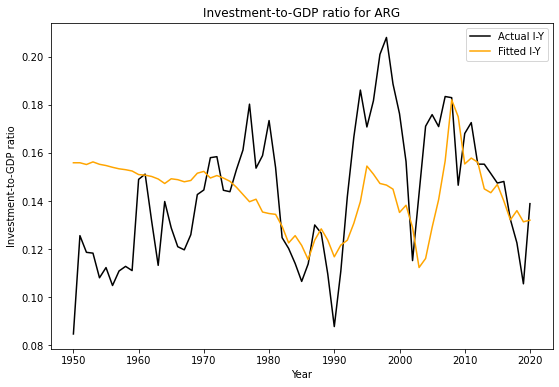

In [32]:
graph_trajectory("ARG")

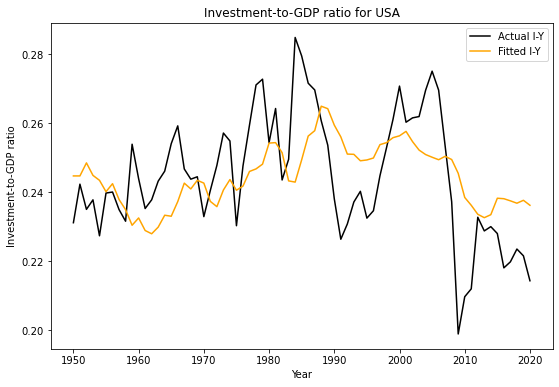

In [33]:
graph_trajectory("USA")

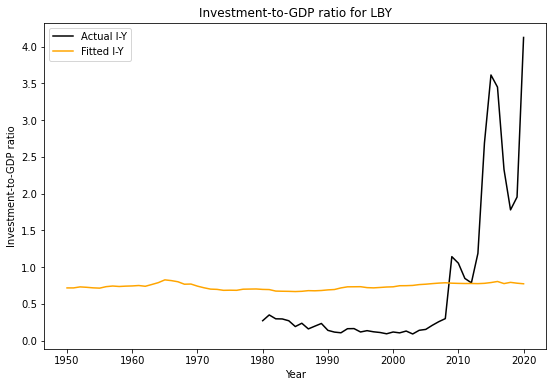

In [35]:
## not-so-good case with Libya
graph_trajectory("LBY")

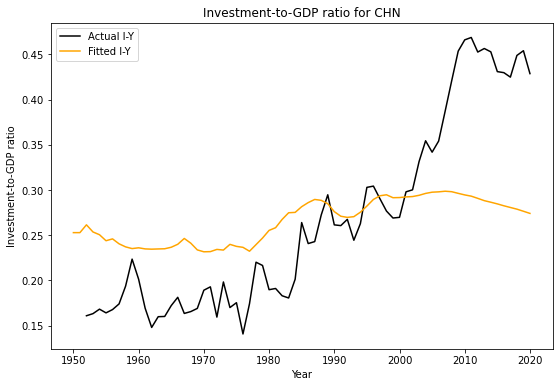

In [36]:
## not-so-good case with China
graph_trajectory("CHN")

We can also see that there are some cases where the I-Y ratios are lesser than 0 or larger than 1; however, these are all from the original sources (mostly from PWT10.0's `csh_i` variable, except for `LBY` where the values are from IMF). Therefore, we will keep things as is and accept these values.

In [39]:
fitted_iy.loc[(fitted_iy.iy_ratio_fit < 0) | (fitted_iy.iy_ratio_fit > 1)]

iy_ratio  iy_ratio_pred  iy_ratio_fit
ccode year                                       
AIA   2018  1.052432       0.550340      1.052432
AZE   1992 -0.001813       0.128043     -0.001813
BMU   1998  2.546943       0.200777      2.546943
      1999 -2.952955       0.203000     -2.952955
      2000 -0.478532       0.205229     -0.478532
      2001 -0.425760       0.203696     -0.425760
      2003 -1.306927       0.201958     -1.306927
      2004  1.650324       0.202080      1.650324
LBY   2009  1.141920       0.780794      1.141920
      2010  1.053400       0.778208      1.053400
      2013  1.187220       0.774801      1.187220
      2014  2.687820       0.778909      2.687820
      2015  3.614930       0.789367      3.614930
      2016  3.450120       0.804023      3.450120
      2017  2.328090       0.775422      2.328090
      2018  1.778680       0.792056      1.778680
      2019  1.953320       0.780638      1.953320
      2020  4.125560       0.772818      4.125560
MLT   1960  1.667221       0.387771      1.667221
      1961  1.112970       0.394081      1.112970
      1963  3.165007       0.376821      3.165007
NIC   1979 -0.101107       0.184346     -0.101107
SXM   2014  1.462408       0.306625      1.462408
TCA   2003  8.122809       0.595581      8.122809
      2006  1.587445       0.603358      1.587445
      2007  1.391035       0.616922      1.391035
VEN   2017 -0.029723       0.322299     -0.029723

## Updating the predicted I-Y ratios and re-exporting

In [41]:
iyinfo = pd.read_parquet(
    sset.DIR_YPK_INT / "gdp_gdppc_pop_capital_1950_2020_post_ypk3.parquet"
)
iyinfo = iyinfo.merge(
    fitted_iy[["iy_ratio_fit"]],
    how="left",
    left_index=True,
    right_index=True,
)

iyinfo.loc[
    ~pd.isnull(iyinfo.iy_ratio_fit) & pd.isnull(iyinfo.iy_ratio), "iy_ratio_source"
] = "hist_reg_project"

iyinfo.loc[("SHN", list(range(1950, 2014))), "iy_ratio_source"] = "hist_reg_project_avg"
iyinfo.to_parquet(
    sset.DIR_YPK_INT / "gdp_gdppc_pop_capital_1950_2020_post_ypk4.parquet"
)